## Import Necessary Libraries

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50, MobileNetV2, VGG16, VGG19, InceptionV3, EfficientNetB0
)
from tensorflow.keras.applications import ConvNeXtSmall  # ConvNeXt is available in newer TensorFlow versions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import ViTImageProcessor, TFAutoModelForImageClassification
from tensorflow.keras import layers, models

In [6]:
# Function to load images and labels
def load_images_and_labels(folder_path, subfolders, img_size=(224, 224)):
    images = []
    labels = []
    label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}

    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, img_size)  # Resize to 224x224
                images.append(img_resized)
                labels.append(label_map[subfolder])

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [8]:
# Function to preprocess data
def preprocess_data(images, labels, num_classes):
    images = images.astype('float32') / 255.0  # Normalize
    labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=num_classes)  # One-hot encode
    return images, labels_one_hot

In [5]:
# Function to create a model
def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [6]:
# Function to augment data
def augment_data(x_train, y_train):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(x_train)
    return datagen

In [7]:
# Function to combine original and augmented data
def combine_original_and_augmented(x_train, y_train, datagen, batch_size=32):
    augmented_images = []
    augmented_labels = []
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
        augmented_images.append(x_batch)
        augmented_labels.append(y_batch)
        if len(augmented_images) * batch_size >= len(x_train):  # Stop when we have enough augmented data
            break

    augmented_images = np.vstack(augmented_images)
    augmented_labels = np.vstack(augmented_labels)

    # Combine original and augmented data
    combined_images = np.vstack([x_train, augmented_images])
    combined_labels = np.vstack([y_train, augmented_labels])
    return combined_images, combined_labels

In [8]:
# Function to evaluate and plot results
def evaluate_and_plot(model, x_test, y_test, subfolders, model_name):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=subfolders, yticklabels=subfolders)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Classification Report
    print(f"Classification Report - {model_name}")
    print(classification_report(y_true, y_pred_classes, target_names=subfolders))

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f'Test accuracy - {model_name}: {test_acc}')
    print(f'Test loss - {model_name}: {test_loss}')

In [9]:
# Function to plot test images with true and predicted labels
def plot_test_images(model, x_test, y_test, subfolders, num_images=5):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(x_test[i])
        plt.title(f'True: {subfolders[y_true[i]]}\nPred: {subfolders[y_pred_classes[i]]}')
        plt.axis('off')
    plt.show()

## Load and Explore the Dataset

In [ ]:
folder_path = "/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset"
subfolders = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}

# Load and preprocess data
images, labels = load_images_and_labels(folder_path, subfolders)
images, labels_one_hot = preprocess_data(images, labels, num_classes=len(subfolders))

## Visualize sample images and class distributions

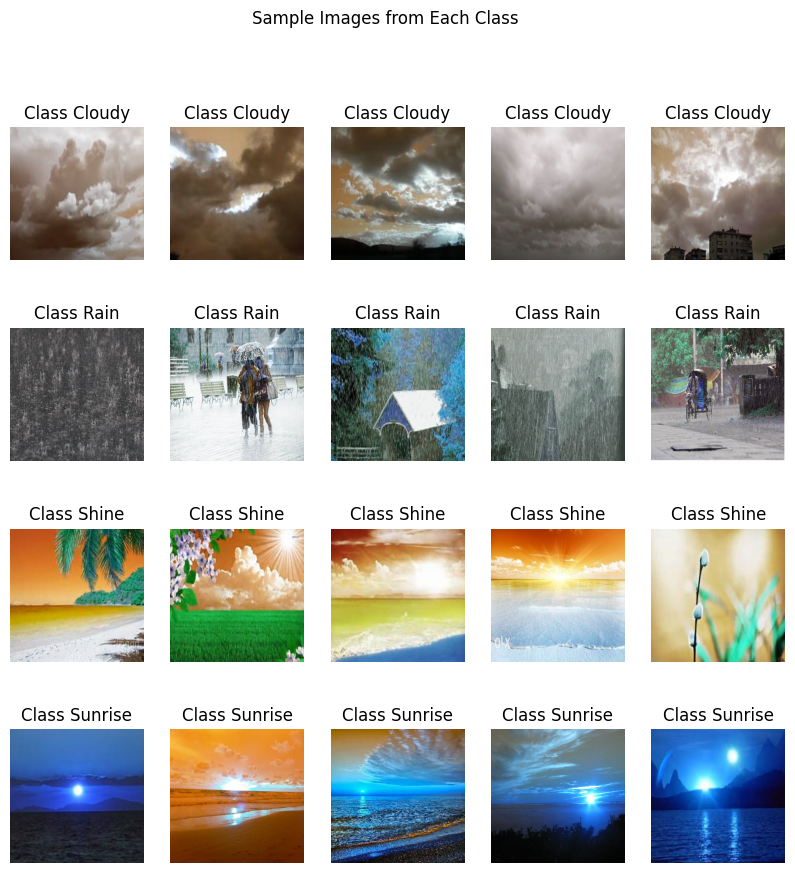

In [11]:
# Plot 5 images for each class
plt.figure(figsize=(10, 10))
for i, subfolder in enumerate(subfolders):
    class_indices = np.where(labels == label_map[subfolder])[0]
    for j in range(5):
        plt.subplot(len(subfolders), 5, i * 5 + j + 1)
        plt.imshow(images[class_indices[j]])
        plt.title(f'Class {subfolder}')
        plt.axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

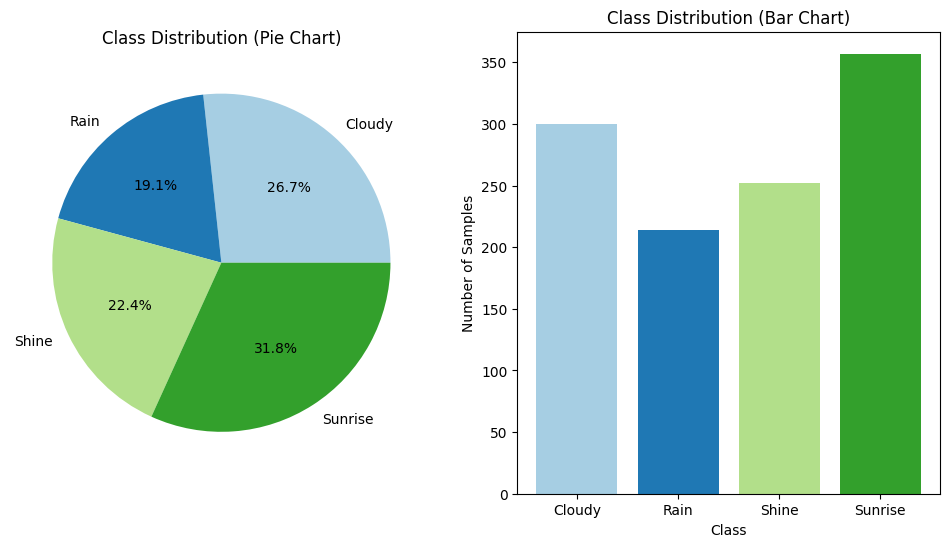

In [18]:
# Plot class distribution as a pie and bar chart
class_counts = np.bincount(labels)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(class_counts, labels=subfolders, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Class Distribution (Pie Chart)')

plt.subplot(1, 2, 2)
plt.bar(subfolders, class_counts, color=plt.cm.Paired.colors)
plt.title('Class Distribution (Bar Chart)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

plt.show()

## Split the dataset into training and test sets

In [12]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(898, 224, 224, 3) (898, 4)
(225, 224, 224, 3) (225, 4)


## Apply Data Augmentation to enhance model generalization

In [13]:
# Augment data
datagen = augment_data(x_train, y_train)
combined_images, combined_labels = combine_original_and_augmented(x_train, y_train, datagen)

print(combined_images.shape,combined_labels.shape)

(1796, 224, 224, 3) (1796, 4)


## Build CNN Architectures

In [24]:
# Define models to train
models = {
        "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        "VGG19": VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        "InceptionV3": InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        "ConvNeXtSmall": ConvNeXtSmall(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    }

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
198551472/198551472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Train and Evaluate CNN Models

Training ResNet50...
Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.2686 - loss: 1.5908 - val_accuracy: 0.1956 - val_loss: 1.3781
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.3173 - loss: 1.3776 - val_accuracy: 0.3378 - val_loss: 1.4403
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.3478 - loss: 1.3436 - val_accuracy: 0.4489 - val_loss: 1.3323
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.4127 - loss: 1.2840 - val_accuracy: 0.5200 - val_loss: 1.2153
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.4561 - loss: 1.2122 - val_accuracy: 0.4178 - val_loss: 1.2155
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.4408 - loss: 1.2018 - val_accuracy: 0.2978 - val_loss: 1.3082
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.3662 - loss: 1.2678 - val_accuracy: 0.5067 - val_loss: 1.1978
Epoch 8/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.4865 - loss: 1.1

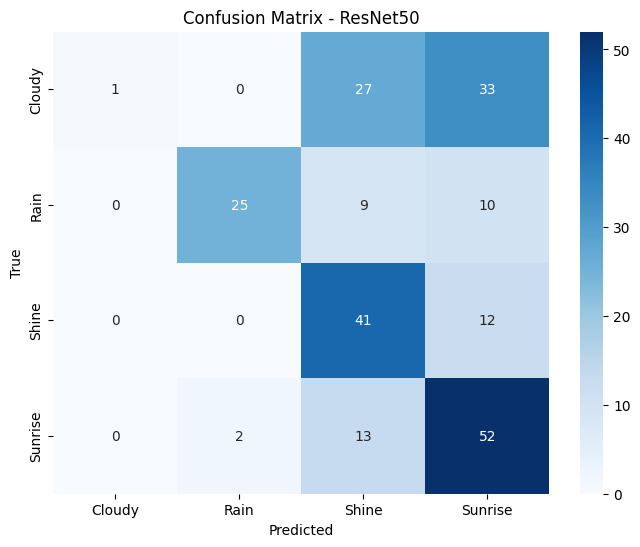

Classification Report - ResNet50
              precision    recall  f1-score   support

      Cloudy       1.00      0.02      0.03        61
        Rain       0.93      0.57      0.70        44
       Shine       0.46      0.77      0.57        53
     Sunrise       0.49      0.78      0.60        67

    accuracy                           0.53       225
   macro avg       0.72      0.53      0.48       225
weighted avg       0.70      0.53      0.46       225

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.5334 - loss: 1.0835
Test accuracy - ResNet50: 0.5288888812065125
Test loss - ResNet50: 1.0758616924285889
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


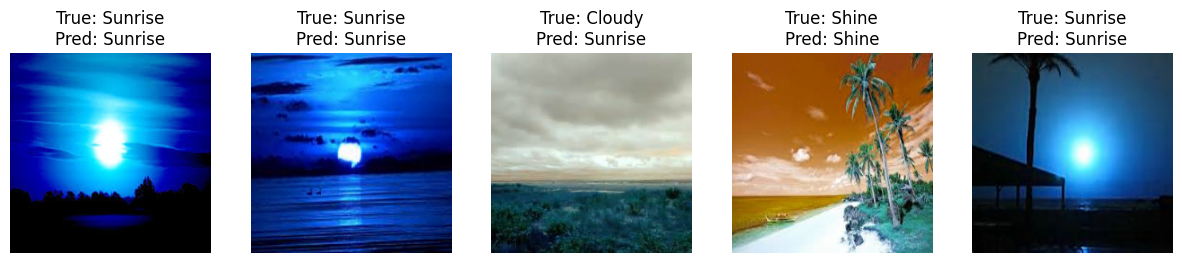

---------------------------------------------------------------------------------
Training MobileNetV2...
Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 268ms/step - accuracy: 0.6499 - loss: 1.0984 - val_accuracy: 0.9067 - val_loss: 0.2787
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9155 - loss: 0.2331 - val_accuracy: 0.9289 - val_loss: 0.2124
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9607 - loss: 0.1209 - val_accuracy: 0.9289 - val_loss: 0.1934
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9881 - loss: 0.0585 - val_accuracy: 0.9333 - val_loss: 0.1749
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9965 - loss: 0.0315 - val_accuracy: 0.9467 - val_loss: 0.1563
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9946 - loss: 0.0302 - val_accuracy: 0.9333 - val_loss: 0.1598
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9999 - loss: 0.0155 - val_accuracy: 0.9467 - val_loss: 0.1642
Epo

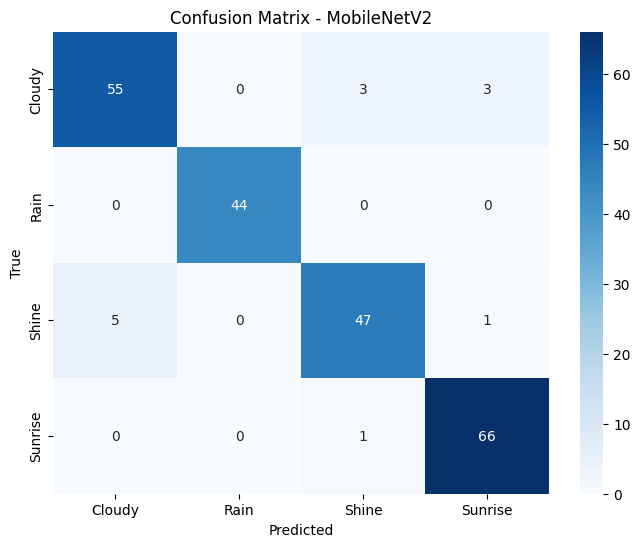

Classification Report - MobileNetV2
              precision    recall  f1-score   support

      Cloudy       0.92      0.90      0.91        61
        Rain       1.00      1.00      1.00        44
       Shine       0.92      0.89      0.90        53
     Sunrise       0.94      0.99      0.96        67

    accuracy                           0.94       225
   macro avg       0.95      0.94      0.94       225
weighted avg       0.94      0.94      0.94       225

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.9605 - loss: 0.1133
Test accuracy - MobileNetV2: 0.9422222375869751
Test loss - MobileNetV2: 0.17132225632667542
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


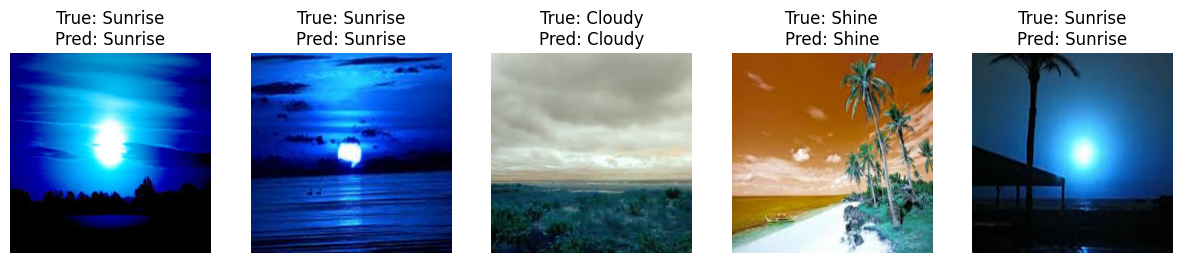

---------------------------------------------------------------------------------
Training VGG16...
Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 410ms/step - accuracy: 0.5109 - loss: 1.1493 - val_accuracy: 0.7511 - val_loss: 0.6957
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.7895 - loss: 0.6354 - val_accuracy: 0.8178 - val_loss: 0.5327
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.8400 - loss: 0.4858 - val_accuracy: 0.8089 - val_loss: 0.4912
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.8807 - loss: 0.3698 - val_accuracy: 0.8311 - val_loss: 0.4257
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.8735 - loss: 0.3601 - val_accuracy: 0.8578 - val_loss: 0.3589
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - accuracy: 0.9020 - loss: 0.2948 - val_accuracy: 0.8756 - val_loss: 0.3329
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - accuracy: 0.9177 - loss: 0.2593 - val_accuracy: 0.8489 - val_loss: 0.33

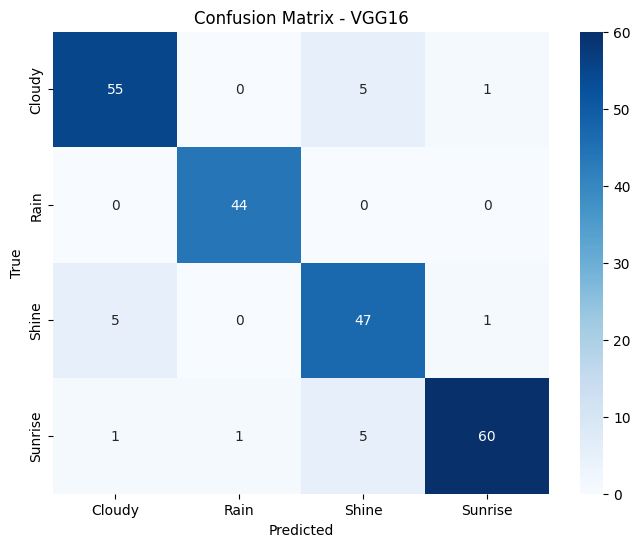

Classification Report - VGG16
              precision    recall  f1-score   support

      Cloudy       0.90      0.90      0.90        61
        Rain       0.98      1.00      0.99        44
       Shine       0.82      0.89      0.85        53
     Sunrise       0.97      0.90      0.93        67

    accuracy                           0.92       225
   macro avg       0.92      0.92      0.92       225
weighted avg       0.92      0.92      0.92       225

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.9306 - loss: 0.1871
Test accuracy - VGG16: 0.9155555367469788
Test loss - VGG16: 0.20742298662662506
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


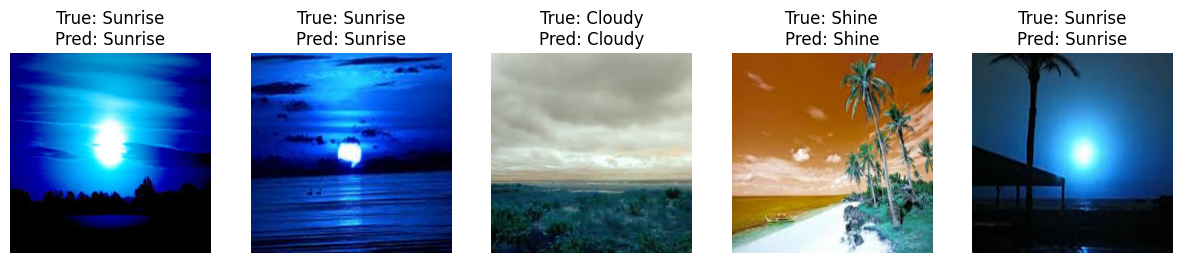

---------------------------------------------------------------------------------
Training VGG19...
Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 470ms/step - accuracy: 0.4270 - loss: 1.2677 - val_accuracy: 0.7156 - val_loss: 0.8258
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 413ms/step - accuracy: 0.7529 - loss: 0.7515 - val_accuracy: 0.7600 - val_loss: 0.6231
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 423ms/step - accuracy: 0.8419 - loss: 0.5418 - val_accuracy: 0.7956 - val_loss: 0.5069
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 405ms/step - accuracy: 0.8566 - loss: 0.4549 - val_accuracy: 0.8444 - val_loss: 0.4269
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 397ms/step - accuracy: 0.8807 - loss: 0.3880 - val_accuracy: 0.8667 - val_loss: 0.4010
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 393ms/step - accuracy: 0.8695 - loss: 0.3740 - val_accuracy: 0.8578 - val_loss: 0.3882
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step - accuracy: 0.9055 - loss: 0.2962 - val_accuracy: 0.8800 - val_loss: 0.32

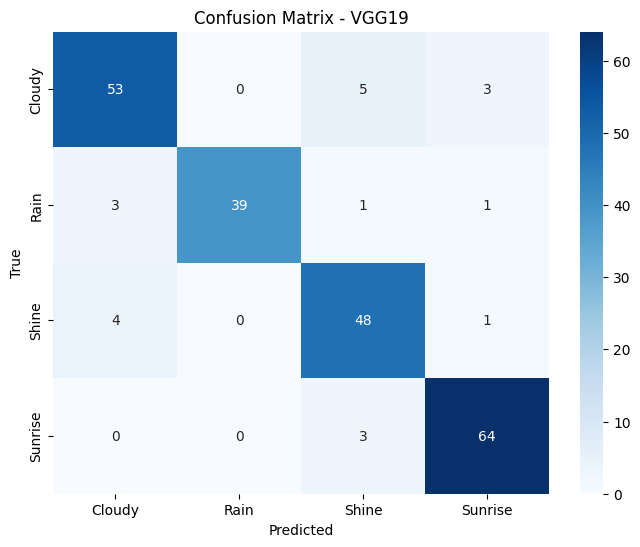

Classification Report - VGG19
              precision    recall  f1-score   support

      Cloudy       0.88      0.87      0.88        61
        Rain       1.00      0.89      0.94        44
       Shine       0.84      0.91      0.87        53
     Sunrise       0.93      0.96      0.94        67

    accuracy                           0.91       225
   macro avg       0.91      0.90      0.91       225
weighted avg       0.91      0.91      0.91       225

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.9090 - loss: 0.2607
Test accuracy - VGG19: 0.9066666960716248
Test loss - VGG19: 0.26095443964004517
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


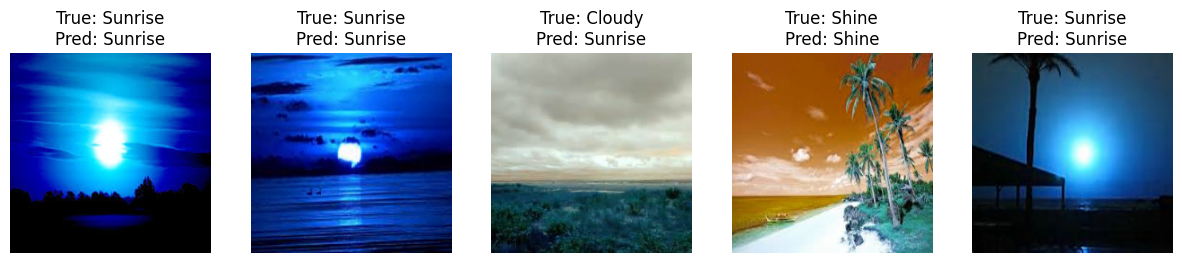

---------------------------------------------------------------------------------
Training InceptionV3...
Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 477ms/step - accuracy: 0.5509 - loss: 1.4139 - val_accuracy: 0.7956 - val_loss: 0.5511
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.8615 - loss: 0.3772 - val_accuracy: 0.9111 - val_loss: 0.2691
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9516 - loss: 0.1540 - val_accuracy: 0.9200 - val_loss: 0.2729
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9726 - loss: 0.0974 - val_accuracy: 0.9111 - val_loss: 0.2656
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9827 - loss: 0.0750 - val_accuracy: 0.9067 - val_loss: 0.2696
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.9825 - loss: 0.0766 - val_accuracy: 0.9022 - val_loss: 0.2553
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.9928 - loss: 0.0477 - val_accuracy: 0.9067 - val_loss: 0.25

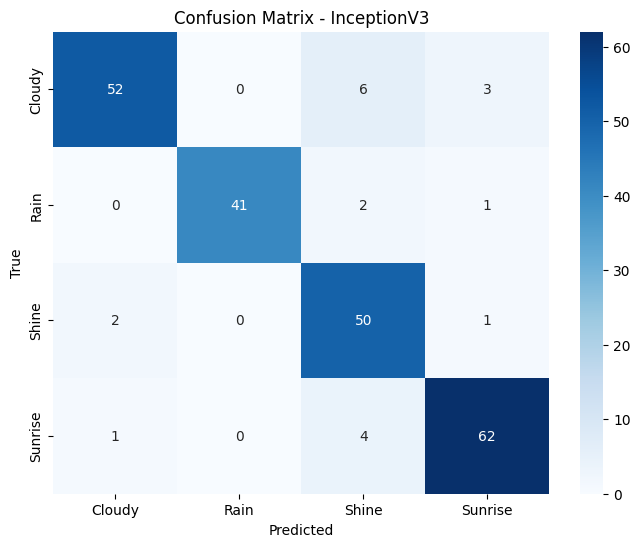

Classification Report - InceptionV3
              precision    recall  f1-score   support

      Cloudy       0.95      0.85      0.90        61
        Rain       1.00      0.93      0.96        44
       Shine       0.81      0.94      0.87        53
     Sunrise       0.93      0.93      0.93        67

    accuracy                           0.91       225
   macro avg       0.92      0.91      0.91       225
weighted avg       0.92      0.91      0.91       225

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 384ms/step - accuracy: 0.9320 - loss: 0.2352
Test accuracy - InceptionV3: 0.9111111164093018
Test loss - InceptionV3: 0.29984670877456665
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


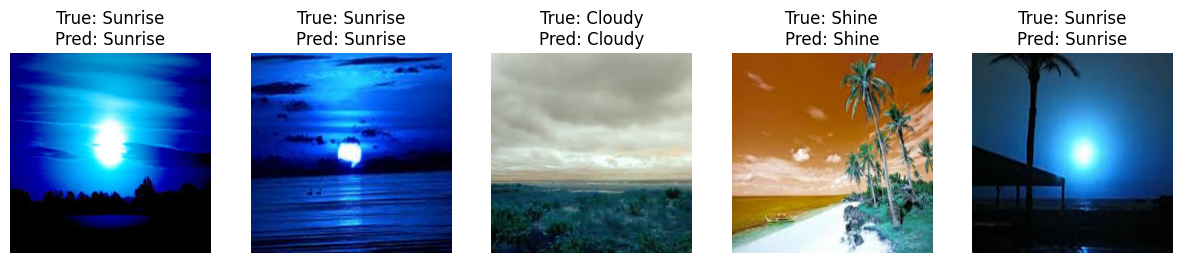

---------------------------------------------------------------------------------
Training EfficientNetB0...
Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 609ms/step - accuracy: 0.3099 - loss: 1.3811 - val_accuracy: 0.2711 - val_loss: 1.3802
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3096 - loss: 1.3720 - val_accuracy: 0.2978 - val_loss: 1.3792
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.3303 - loss: 1.3695 - val_accuracy: 0.2978 - val_loss: 1.3772
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3186 - loss: 1.3684 - val_accuracy: 0.2978 - val_loss: 1.3782
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3287 - loss: 1.3708 - val_accuracy: 0.2978 - val_loss: 1.3778
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3261 - loss: 1.3681 - val_accuracy: 0.2978 - val_loss: 1.3753
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3226 - loss: 1.3675 - val_accuracy: 0.2978 - val_loss: 1.3760


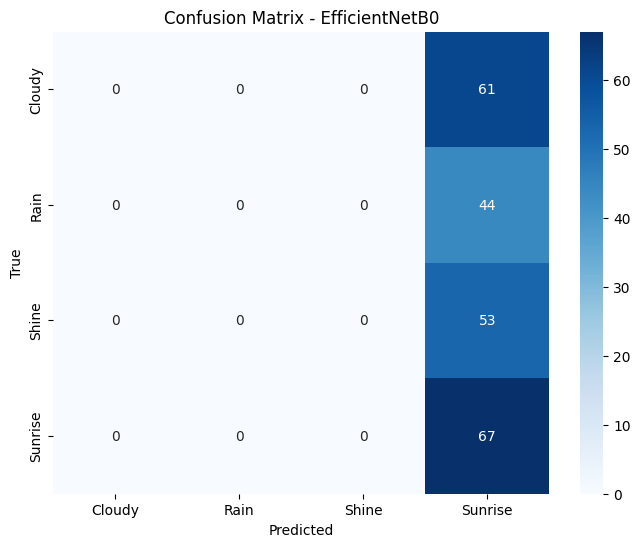

Classification Report - EfficientNetB0
              precision    recall  f1-score   support

      Cloudy       0.00      0.00      0.00        61
        Rain       0.00      0.00      0.00        44
       Shine       0.00      0.00      0.00        53
     Sunrise       0.30      1.00      0.46        67

    accuracy                           0.30       225
   macro avg       0.07      0.25      0.11       225
weighted avg       0.09      0.30      0.14       225



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 492ms/step - accuracy: 0.3016 - loss: 1.3788
Test accuracy - EfficientNetB0: 0.29777777194976807
Test loss - EfficientNetB0: 1.3760443925857544
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


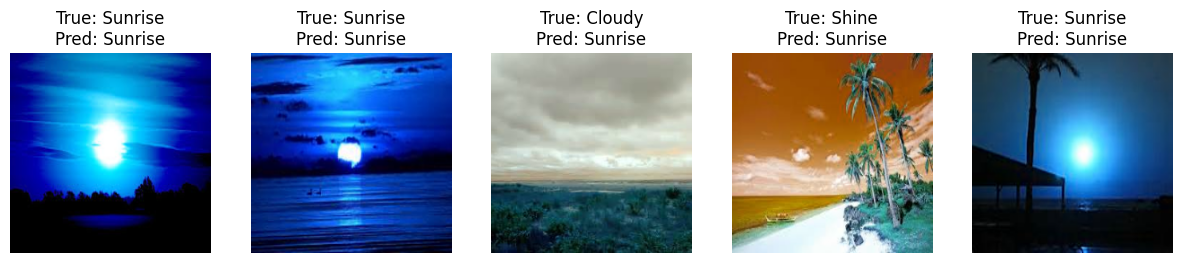

---------------------------------------------------------------------------------
Training ConvNeXtSmall...
Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 44s 904ms/step - accuracy: 0.2877 - loss: 1.5110 - val_accuracy: 0.3200 - val_loss: 1.4099
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 574ms/step - accuracy: 0.3446 - loss: 1.3609 - val_accuracy: 0.3600 - val_loss: 1.3520
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 560ms/step - accuracy: 0.3446 - loss: 1.3544 - val_accuracy: 0.3644 - val_loss: 1.3130
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 535ms/step - accuracy: 0.4186 - loss: 1.2773 - val_accuracy: 0.4044 - val_loss: 1.3141
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 534ms/step - accuracy: 0.4129 - loss: 1.2849 - val_accuracy: 0.4178 - val_loss: 1.2441
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 548ms/step - accuracy: 0.4343 - loss: 1.2223 - val_accuracy: 0.4978 - val_loss: 1.2140
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 553ms/step - accuracy: 0.4718 - loss: 1.1848 - val_accuracy: 0.4222 - val_lo

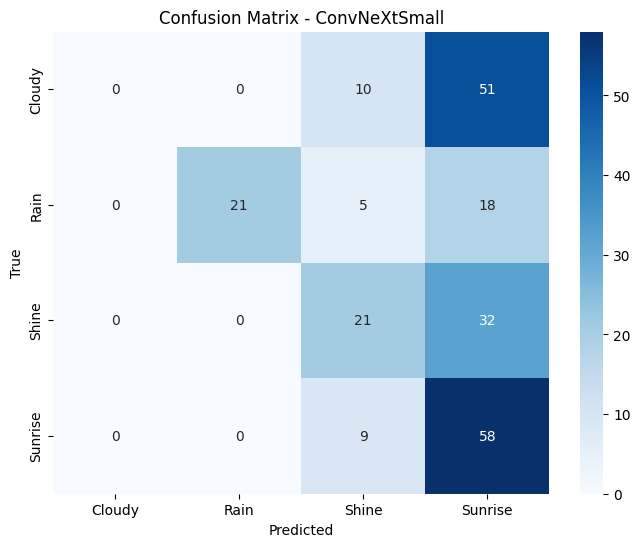

Classification Report - ConvNeXtSmall
              precision    recall  f1-score   support

      Cloudy       0.00      0.00      0.00        61
        Rain       1.00      0.48      0.65        44
       Shine       0.47      0.40      0.43        53
     Sunrise       0.36      0.87      0.51        67

    accuracy                           0.44       225
   macro avg       0.46      0.43      0.40       225
weighted avg       0.41      0.44      0.38       225



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 485ms/step - accuracy: 0.4377 - loss: 1.1669
Test accuracy - ConvNeXtSmall: 0.4444444477558136
Test loss - ConvNeXtSmall: 1.1550841331481934
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step


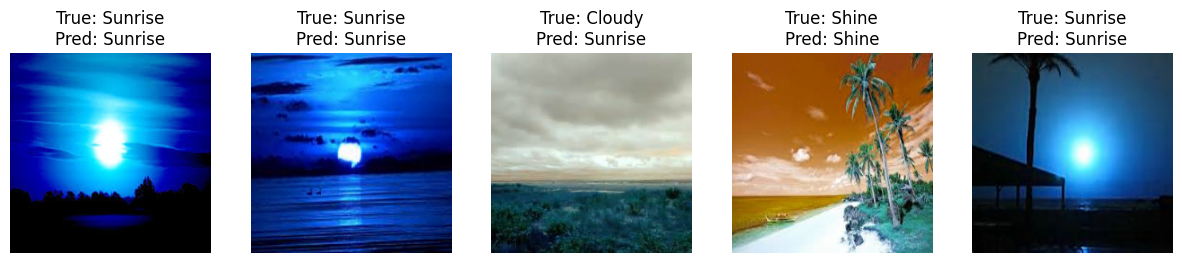

---------------------------------------------------------------------------------


In [31]:
# Train and evaluate each model
for model_name, base_model in models.items():
    print(f"Training {model_name}...")
    model = create_model(base_model, num_classes=len(subfolders))
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(combined_images, combined_labels, batch_size=64, epochs=12, validation_data=(x_test, y_test))

    # Evaluate the model
    evaluate_and_plot(model, x_test, y_test, subfolders, model_name=model_name)

    # Plot test images
    plot_test_images(model, x_test, y_test, subfolders)

    print('---------------------------------------------------------------------------------')

# Implement Vision Transformer (ViT)

## 1 - Pretrained ViT: Fine-tune a pretrained ViT model

/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'rescale'
  return self.preprocess(images, **kwargs)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and

Training the Model...
Epoch 1/20
113/113 [==============================] - 117s 783ms/step - loss: 0.9797 - accuracy: 0.5373 - val_loss: 0.6911 - val_accuracy: 0.7289
Epoch 2/20
113/113 [==============================] - 85s 752ms/step - loss: 0.6337 - accuracy: 0.7199 - val_loss: 0.5850 - val_accuracy: 0.7200
Epoch 3/20
113/113 [==============================] - 85s 751ms/step - loss: 0.5747 - accuracy: 0.7517 - val_loss: 0.5328 - val_accuracy: 0.7289
Epoch 4/20
113/113 [==============================] - 85s 754ms/step - loss: 0.5306 - accuracy: 0.7545 - val_loss: 0.6095 - val_accuracy: 0.7333
Epoch 5/20
113/113 [==============================] - 85s 753ms/step - loss: 0.5804 - accuracy: 0.7567 - val_loss: 0.8545 - val_accuracy: 0.6178
Epoch 6/20
113/113 [==============================] - 85s 749ms/step - loss: 0.5346 - accuracy: 0.7483 - val_loss: 0.4915 - val_accuracy: 0.7422
Epoch 7/20
113/113 [==============================] - 85s 753ms/step - loss: 0.4543 - accuracy: 0.7984 - va

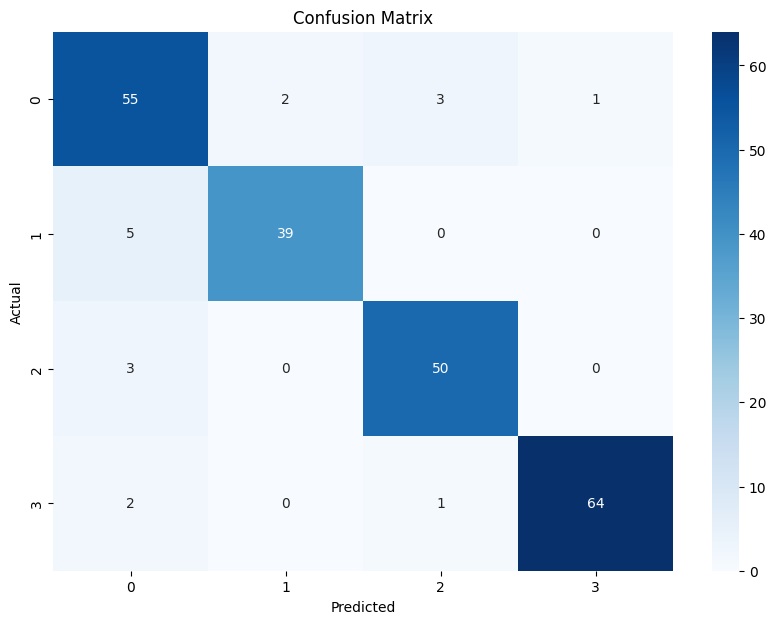


Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.85      0.90      0.87        61
        Rain       0.95      0.89      0.92        44
       Shine       0.93      0.94      0.93        53
     Sunrise       0.98      0.96      0.97        67

    accuracy                           0.92       225
   macro avg       0.93      0.92      0.92       225
weighted avg       0.93      0.92      0.93       225



In [ ]:
# ViT Pre-trained Model
from transformers import ViTImageProcessor, TFAutoModelForImageClassification
from PIL import Image  # For converting images to PIL format

# ViT Pre-trained Model Name
model_name = "google/vit-base-patch16-224-in21k"

# Load Preprocessor with rescale=False
processor = ViTImageProcessor.from_pretrained(model_name)

# Convert images to PIL format (required by ViTImageProcessor)
def convert_to_pil(images):
    return [Image.fromarray((image * 255).astype(np.uint8)) for image in images]

# Convert to Tensor
train_inputs = processor(images=convert_to_pil(combined_images), return_tensors="tf", rescale=False)["pixel_values"]
test_inputs = processor(images=convert_to_pil(x_test), return_tensors="tf", rescale=False)["pixel_values"]

# Convert one-hot labels to integer labels
train_labels = np.argmax(combined_labels, axis=1)
test_labels = np.argmax(y_test, axis=1)

# Load ViT Pretrained Model
model = TFAutoModelForImageClassification.from_pretrained(model_name, num_labels=4)

# Compile the Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

# Train the Model
print("Training the Model...")
history = model.fit(train_inputs, train_labels, epochs=20, batch_size=16, validation_data=(test_inputs, test_labels))

# Evaluate the Model
print("\nEvaluating the Model...")
test_loss, test_acc = model.evaluate(test_inputs, test_labels)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# Predictions
y_pred = model.predict(test_inputs).logits
y_pred = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred, target_names=subfolders))  # Use subfolder names

## ViT from Scratch: Train a ViT model from scratch

In [26]:
# Vision Transformer parameters
patch_size = 16  # Adjusted for 224x224 images
num_patches = (224 // patch_size) ** 2  # Number of patches
projection_dim = 64  # Embedding dimension
transformer_layers = 6  # Number of transformer layers
num_heads = 8  # Number of attention heads
mlp_dim = 128  # Dimension of the MLP layer in the transformer block

In [ ]:
# Create Vision Transformer model from scratch
def create_vit_model():
    inputs = layers.Input(shape=(224, 224, 3))  # Input shape for 224x224x3 images

    # Create patches
    patches = layers.Lambda(
        lambda x: tf.image.extract_patches(
            images=x,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
    )(inputs)
    patches = layers.Reshape((num_patches, patch_size * patch_size * 3))(patches)

    # Project patches
    patch_embeddings = layers.Dense(projection_dim)(patches)

    # Positional embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embeddings = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    embeddings = patch_embeddings + position_embeddings

    # Transformer blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(embeddings)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, embeddings])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(mlp_dim, activation="relu")(x3)
        x3 = layers.Dense(projection_dim)(x3)
        embeddings = layers.Add()([x3, x2])

    # Classification head
    representation = layers.GlobalAveragePooling1D()(embeddings)
    representation = layers.Dropout(0.5)(representation)
    outputs = layers.Dense(4, activation="softmax")(representation)  # 4 output classes for your dataset

    return models.Model(inputs=inputs, outputs=outputs)

In [29]:
# Create and compile model
model = create_vit_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model on your dataset
history = model.fit(combined_images, combined_labels, batch_size=64, epochs=30, validation_data=(x_test, y_test))

# Evaluate the Model
print("\nEvaluating the Model...")
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 743ms/step - accuracy: 0.4167 - loss: 2.3317 - val_accuracy: 0.6889 - val_loss: 0.8911
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.6735 - loss: 0.9094 - val_accuracy: 0.7244 - val_loss: 0.7356
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.7262 - loss: 0.7161 - val_accuracy: 0.7333 - val_loss: 0.5423
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.7591 - loss: 0.6124 - val_accuracy: 0.8133 - val_loss: 0.4448
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.7551 - loss: 0.5924 - val_accuracy: 0.7067 - val_loss: 0.7617
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.7663 - loss: 0.6200 - val_accuracy: 0.7422 - val_loss: 0.5414
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.7909 - loss: 0.5255 - val_accuracy: 0.7822 - val_loss: 0.4800
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.7909 - loss: 0.5007 - val_accuracy: 0

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step


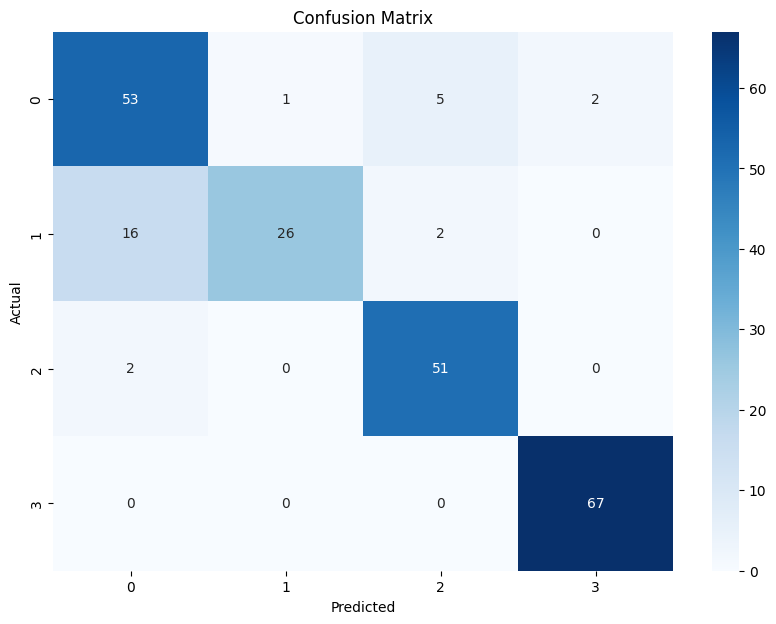


Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.75      0.87      0.80        61
        Rain       0.96      0.59      0.73        44
       Shine       0.88      0.96      0.92        53
     Sunrise       0.97      1.00      0.99        67

    accuracy                           0.88       225
   macro avg       0.89      0.86      0.86       225
weighted avg       0.89      0.88      0.87       225



In [24]:
# Predictions
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Confusion Matrix
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class labels
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=subfolders))  # Use subfolder names

## Compare CNN vs. Transformer-Based Models

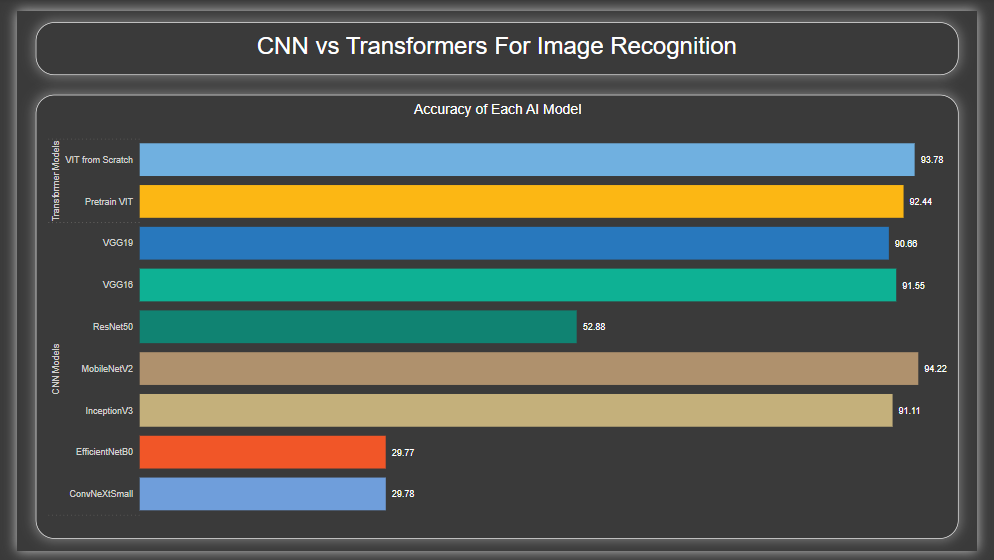